# Question A3

Find the optimal number of hidden neurons for first hidden layer of the 4-layer network (3 hidden layers, output layer) designed in Question 1 and 2

#### Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}. Continue using 5-fold cross validation on training dataset. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

This might take a while to run, approximately 20 - 30 min, so plan your time carefully.

1. Firstly, we import relevant libraries.

In [61]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed

# setting seed
set_seed()

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [62]:
# YOUR CODE HERE
from common_utils import (
    MLP,
    CustomDataset,
    preprocess_dataset,
    intialise_loaders,
    split_dataset,
    preprocess_dataset,
)
loss_fn = nn.BCELoss()

3. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [63]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader)
    train_loss, train_acc = 0, 0
    for X, y in dataloader:
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y.reshape(-1, 1))
        optimizer.zero_grad() # initialize gradient calculations
        loss.backward() # compute gradients
        optimizer.step() # execute one step of GD

        train_loss += loss.item()
        train_acc += (torch.sum(torch.eq(pred > 0.5, y.reshape(-1, 1))).item() / len(pred))

    train_loss /= size
    train_acc /= size
    return train_loss, train_acc

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader)
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y.reshape(-1, 1)).item()
            test_acc += (torch.sum(torch.eq(pred > 0.5, y.reshape(-1, 1))).item() / len(pred))
    model.train()
    test_loss /= size
    test_acc /= size
    return test_loss, test_acc

def evaluate_fold(train_dataloader, test_dataloader, num_epochs, model, loss_fn, optimizer):
    train_loss_, train_acc_, test_loss_, test_acc_ = [], [], [], []

    for epoch in tqdm.tqdm(range(num_epochs)):

        start = time.time()

        train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer)

        end = time.time()

        test_loss, test_acc = test_loop(test_dataloader, model, loss_fn)
        train_loss_.append(train_loss), train_acc_.append(train_acc)
        test_loss_.append(test_loss), test_acc_.append(test_acc)

    last_epoch_time = end-start

    return train_loss_, train_acc_, test_loss_, test_acc_, last_epoch_time
# def train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size):

#     # YOUR CODE HERE

#     return train_accuracies, train_losses, test_accuracies, test_losses, times

In [64]:
from collections import defaultdict

def find_optimal_hyperparameter(X_train, y_train, parameters, mode, batch_size):

    # YOUR CODE HERE
    cross_validation_accuracies = {}
    cross_validation_val_accuracies, cross_validation_train_accuracies, cross_validation_times = defaultdict(list), defaultdict(list), defaultdict(list)

    ## initialize model hyperparams here
    num_epochs = 20
    lr = 0.001
    no_features = 77
    no_hidden = 3
    no_labels = 1

    for hidden_neurons in parameters:

        ## split datasets into k folds here for optimal batch size
        kf = KFold(n_splits=5, shuffle=True)
        
        for i, (train_index, test_index) in enumerate(kf.split(X_train)):

            ## initialize new model for each cv split to avoid data leakage and fair evaluation
            model = MLP(no_features, no_hidden, no_labels, no_hidden_neurons = hidden_neurons)
            optimizer = torch.optim.Adam(model.parameters(), lr = lr)
            loss_fn = nn.BCELoss()

            eval_params = {
                'num_epochs': num_epochs,
                'model': model,
                'loss_fn': loss_fn,
                'optimizer': optimizer,
            }

            X_train_subset = X_train[train_index]
            y_train_subset = y_train[train_index]
            X_val_subset = X_train[test_index]
            y_val_subset = y_train[test_index]

            X_train_scaled, X_val_scaled = preprocess_dataset(X_train_subset, X_val_subset)

            ## initialize dataloaders and train model using train() function
            train_dataloader, val_dataloader = intialise_loaders(X_train_scaled, y_train_subset, X_val_scaled, y_val_subset, batch_size = batch_size)
            train_loss_, train_acc_, val_loss_, val_acc_, last_epoch_time = evaluate_fold(train_dataloader, val_dataloader, **eval_params)

            ## collate and return result
            cross_validation_train_accuracies[hidden_neurons].append(train_acc_)
            cross_validation_val_accuracies[hidden_neurons].append(val_acc_)
            cross_validation_times[hidden_neurons].append(last_epoch_time)

            cross_validation_accuracies['train'] = cross_validation_train_accuracies
            cross_validation_accuracies['val'] = cross_validation_val_accuracies

    
    return cross_validation_accuracies, cross_validation_times

'''
optimal_bs = 0. Fill your optimal batch size in the following code.
'''
# YOUR CODE HERE
num_neurons = [(64, 128, 128),
               (128, 128, 128),
               (256, 128, 128)]
df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]
X_train, y_train, X_test, y_test = split_dataset(df, ['label','filename'], 0.3, 0)
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train.to_numpy(), y_train, num_neurons, 'num_neurons', 128)

100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


4. Plot the cross-validation accuracies against the number of epochs for different numbers of hidden-layer neurons. Limit the search space of the number of neurons to {64, 128, 256}.

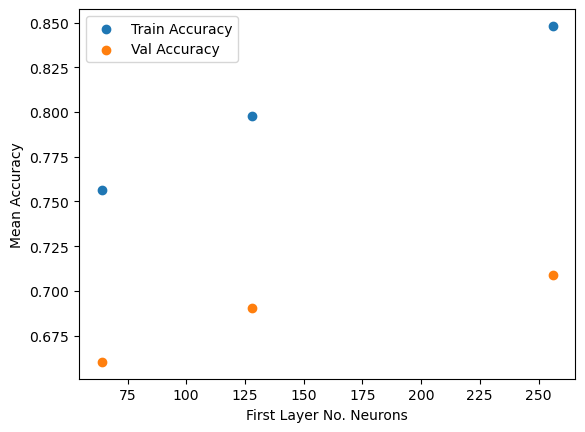

In [65]:
# YOUR CODE HERE

def process_accuracies(accuracy_dict):
    cv_accuracies_df = pd.DataFrame(accuracy_dict).transpose()
    cv_accuracies_df.index = [i[0] for i in cv_accuracies_df.index]
    cv_accuracies_df.index = cv_accuracies_df.index.set_names(["num_neurons"])
    cv_accuracies_df.columns = [f"Fold_{i}" for i in cv_accuracies_df.columns]
    cv_accuracies_df = cv_accuracies_df.explode(list(cv_accuracies_df.columns))
    cv_accuracies_df['mean_acc'] = cv_accuracies_df.mean(axis=1)
    return cv_accuracies_df

mean_train_acc = process_accuracies(cross_validation_accuracies['train'])
mean_val_acc = process_accuracies(cross_validation_accuracies['val'])
mean_train_acc['epoch'] = list(range(1,21))*3
mean_val_acc['epoch'] = list(range(1,21))*3

final_epoch_train_acc = mean_train_acc.loc[mean_train_acc['epoch']==20][['mean_acc']]
final_epoch_val_acc = mean_val_acc.loc[mean_val_acc['epoch']==20][['mean_acc']]

plt.scatter(final_epoch_train_acc.index, final_epoch_train_acc.values, label = "Train Accuracy")
plt.scatter(final_epoch_val_acc.index, final_epoch_val_acc.values, label = "Val Accuracy")
plt.ylabel("Mean Accuracy")
plt.xlabel("First Layer No. Neurons")
plt.legend()

5. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

In [66]:
optimal_neurons = 256
reason = """
From the plots, we can see that as the number of neurons used in the first layer increases, 
both the train and validation accuracy increase. This indicates that overfitting has not occurred yet as the model
is still able to generalise well to the validation set using information from the train set.
However, we can expect that if we keep increasing the neurons, we may see a divergence between the validation and train accuracy.
That is, the train accuracy may continue increasing while the validation accuracy starts dropping.
THis happens due to overfitting where the model learns perfectly the nuances of the training data and as a result,
is unable to generalise well to validation data
"""
# YOUR CODE HERE

6. Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.

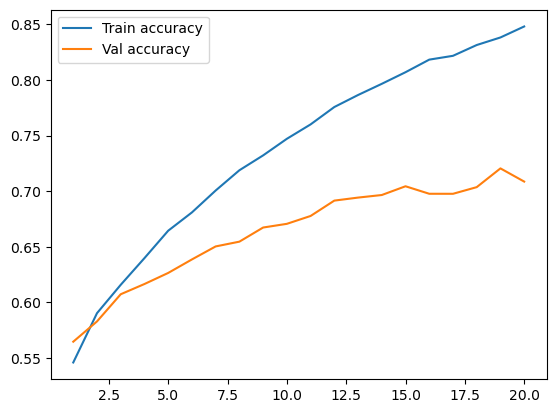

In [68]:
# YOUR CODE HERE
optimal_neuron_train_acc = mean_train_acc.loc[mean_train_acc.index==optimal_neurons]
optimal_neuron_val_acc = mean_val_acc.loc[mean_val_acc.index==optimal_neurons]
f = plt.figure()
plt.plot(optimal_neuron_train_acc['epoch'], optimal_neuron_train_acc['mean_acc'], label="Train accuracy")
plt.plot(optimal_neuron_val_acc['epoch'], optimal_neuron_val_acc['mean_acc'], label = "Val accuracy")
plt.legend()